<a href="https://colab.research.google.com/github/KlaidasKaralevicius/Computer_vision_project/blob/main/Crowd_counting_csrnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dependencies

In [1]:
import numpy as np
import tqdm
import os
import random
from matplotlib import pyplot as plt, cm as c
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
from torchvision import models, transforms

### Model

modelis is git - https://github.com/leeyeehoo/CSRNet-pytorch/tree/master

In [2]:
# official? CSRNet model (no saved model in pytorch, so need to write manually)
class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            for i in range(len(self.frontend.state_dict().items())):
                list(self.frontend.state_dict().items())[i][1].data[:] = list(mod.state_dict().items())[i][1].data[:]
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

### Data

In [3]:
!gdown --id 1zS9LCWu3sOcIjB477mluRQWmGaOgUa2f -O /content/ShanghaiTechTest.zip
!unzip /content/ShanghaiTechTest.zip -d /content/

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1zS9LCWu3sOcIjB477mluRQWmGaOgUa2f
From (redirected): https://drive.google.com/uc?id=1zS9LCWu3sOcIjB477mluRQWmGaOgUa2f&confirm=t&uuid=b481a5e1-85c1-4fc0-95b8-f00a73e8d061
To: /content/ShanghaiTechTest.zip
100% 174M/174M [00:01<00:00, 155MB/s]
Archive:  /content/ShanghaiTechTest.zip
   creating: /content/ShanghaiTech/
   creating: /content/ShanghaiTech/part_A/
   creating: /content/ShanghaiTech/part_A/test_data/
   creating: /content/ShanghaiTech/part_A/test_data/ground-truth/
 extracting: /content/ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_1.mat  
 extracting: /content/ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_10.mat  
 extracting: /content/ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_100

### Extract starting data

In [4]:
# load .mat file and return x,y coordinates of each persons head
def load_gt_mat(mat_path):
    mat = loadmat(mat_path)
    return mat['image_info'][0][0][0][0][0]

# load image and ground truth coords
def load_sample(img_path, gt_path):
    img = cv2.imread(img_path)
    gt_coords = load_gt_mat(gt_path)
    return img, gt_coords

# load dataset (train or test set with image and corresponding ground truth)
def load_dataset(base_path, dataset_type):
    images = []
    gts = []
    img_dir = os.path.join(base_path, f'{dataset_type}_data', 'images')
    gt_dir = os.path.join(base_path, f'{dataset_type}_data', 'ground-truth')

    # get matching .mat and .jpg
    for img_file in os.listdir(img_dir):
        if img_file.endswith('.jpg'):
            # find img and convert its name to mat to find matching pair
            # (pvz. IMG_1, add GT_ before and change jpg to mat to find matching mat file -> IMG_1.jpg = GT_IMG_1.mat)
            img_path = os.path.join(img_dir, img_file)
            gt_file = 'GT_' + img_file.replace('.jpg', '.mat')
            gt_path = os.path.join(gt_dir, gt_file)

            if os.path.exists(gt_path):
                image, gt_coords = load_sample(img_path, gt_path)
                images.append(image)
                gts.append(gt_coords)

    return images, gts

In [5]:
base_path = 'ShanghaiTech/part_A'

train_images, train_gts = load_dataset(base_path, 'train')
test_images, test_gts = load_dataset(base_path, 'test')

### Augment data

In [6]:
# augment using functions (less likely to break)
import albumentations as A
transform = A.Compose([
    A.OneOf([
        A.Rotate(limit=40, border_mode=cv2.BORDER_REFLECT, p=1.0),
        A.NoOp()
    ], p=1.0),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=1.0),
        A.NoOp()
    ], p=1.0),
],
    keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)
)

def augment_img(img, gt_coords):
    augmented_images = [img]
    augmented_gts = [gt_coords]

    for _ in range(6):
        aug = transform(image=img, keypoints=gt_coords)
        augmented_images.append(aug["image"])
        augmented_gts.append(np.array(aug["keypoints"]))

    return augmented_images, augmented_gts

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [7]:
augmented_train_data = []
for img, gt in zip(train_images, train_gts):
    imgs, gts = augment_img(img, gt)
    augmented_train_data.extend(zip(imgs, gts))

### Split to train/validate

In [8]:
input_size = (512, 512)
class CrowdDataset(Dataset):
    # init dataset
    def __init__(self, data, transform=None, input_size=input_size, downsample_ratio=8):
        self.data = data  # list of (image, ground_points) tuples
        self.transform = transform # transform.Compose
        self.input_size = input_size  # size for resizing (W, H)
        self.downsample_ratio = downsample_ratio # how much to downsample (CSRNet structure downsamples 8 times)
    # number of samples
    def __len__(self):
        return len(self.data)
    # get single sample
    def __getitem__(self, idx):
        img, points = self.data[idx]  # raw cv2 image + list of coords
        orig_h, orig_w = img.shape[:2]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)

        # apply transform
        if self.transform:
            img = self.transform(img)
        else:
            img = transform.ToTensor()(img)

        # generate density map
        resized_w, resized_h = self.input_size
        scale_x = resized_w / orig_w
        scale_y = resized_h / orig_h
        points = np.array(points) * [scale_x, scale_y]
        density = self.generate_density_map((resized_h, resized_w), points)
        density = torch.from_numpy(density).unsqueeze(0).float()  # [1, h, w]
        return img, density

    def generate_density_map(self, shape, points, sigma=2):
        h, w = shape[0] // self.downsample_ratio, shape[1] // self.downsample_ratio
        density = np.zeros((h, w), dtype=np.float32)

        if len(points) == 0:
            return density

    # scale coordinates down to match downscaling
        for point in points:
            x = int(point[0] / self.downsample_ratio)
            y = int(point[1] / self.downsample_ratio)

            if x >= w or y >= h:
                continue

        # gaussian window
            size = min(int(6 * sigma + 1), h, w)
            x1 = max(0, x - size // 2)
            y1 = max(0, y - size // 2)
            x2 = min(w, x + size // 2 + 1)
            y2 = min(h, y + size // 2 + 1)

        # coords for gaussian window
            gauss_w = x2 - x1
            gauss_h = y2 - y1

            if gauss_w <= 0 or gauss_h <= 0:
                continue  # skip points that can't fit a kernel

            x_coords = np.arange(gauss_w) - (x - x1)
            y_coords = np.arange(gauss_h) - (y - y1)
            xx, yy = np.meshgrid(x_coords, y_coords)
            g = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
            g /= g.sum()

            density[y1:y2, x1:x2] += g

        return density

In [9]:
transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_data, val_data = train_test_split(augmented_train_data, test_size=0.2, random_state=42)

train_dataset = CrowdDataset(train_data, transform=transform, input_size=input_size)
val_dataset = CrowdDataset(val_data, transform=transform, input_size=input_size)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, num_workers=2, pin_memory=True)

### Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CSRNet(load_weights=True)

for param in model.backend.parameters():
    param.requires_grad = True
model = model.to(device)

# load weights if already fine-tuned before
weights_path = "fine_tuned_weights.pth"
if os.path.exists(weights_path):
    model.load_state_dict(torch.load(weights_path, map_location=device))

# global params
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
# dynamic learning rate
patience = 5
counter = 0
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, verbose=True)

# run training
epochs = 20
best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for imgs, targets in tqdm.tqdm(train_loader):
        imgs = imgs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    # find best model with validation
    model.eval()
    val_loss = 0
    mae = 0.0
    mse = 0.0
    total = 0

    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs = imgs.to(device)
            targets = targets.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            pred_count = outputs.sum(dim=[1,2,3])  # sum over all batches
            true_count = targets.sum(dim=[1,2,3])
            # add more metrics
            mae += (pred_count - true_count).abs().sum().item()
            mse += ((pred_count - true_count) ** 2).sum().item()
            total += imgs.size(0)

    val_loss /= len(val_loader)
    mae /= total
    rmse = (mse / total) ** 0.5
    print(f'Epoch {epoch+1} - train loss: {train_loss:.4f} - val loss: {val_loss:.4f} - mae: {mae:.2f} - rmse: {rmse:.2f}')

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        # save model if validation is better
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'fine_tuned_weights.pth')
    else:
        counter += 1
        # if validation doesn't improve for some time, stop training
        if counter >= patience:
            print("early stopping")
            break

100%|██████████| 105/105 [03:20<00:00,  1.91s/it]


Epoch 1 - train loss: 0.0886 - val loss: 0.0728 - mae: 356.38 - rmse: 473.04


100%|██████████| 105/105 [03:21<00:00,  1.92s/it]


Epoch 2 - train loss: 0.0878 - val loss: 0.0664 - mae: 276.47 - rmse: 397.14


100%|██████████| 105/105 [03:20<00:00,  1.91s/it]


Epoch 3 - train loss: 0.0834 - val loss: 0.0655 - mae: 262.99 - rmse: 386.54


100%|██████████| 105/105 [03:21<00:00,  1.91s/it]


Epoch 4 - train loss: 0.0835 - val loss: 0.0715 - mae: 278.16 - rmse: 442.57


100%|██████████| 105/105 [03:20<00:00,  1.91s/it]


Epoch 5 - train loss: 0.0830 - val loss: 0.0689 - mae: 275.99 - rmse: 420.97


100%|██████████| 105/105 [03:20<00:00,  1.91s/it]


Epoch 6 - train loss: 0.0846 - val loss: 0.0673 - mae: 247.37 - rmse: 399.89


100%|██████████| 105/105 [03:21<00:00,  1.91s/it]


Epoch 7 - train loss: 0.0820 - val loss: 0.0652 - mae: 253.41 - rmse: 406.04


100%|██████████| 105/105 [03:20<00:00,  1.91s/it]


Epoch 8 - train loss: 0.0792 - val loss: 0.0627 - mae: 239.71 - rmse: 374.62


100%|██████████| 105/105 [03:21<00:00,  1.91s/it]


Epoch 9 - train loss: 0.0795 - val loss: 0.0636 - mae: 243.31 - rmse: 382.80


 75%|███████▌  | 79/105 [02:31<00:49,  1.90s/it]

### Model test

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 77.6MB/s]


Original Image


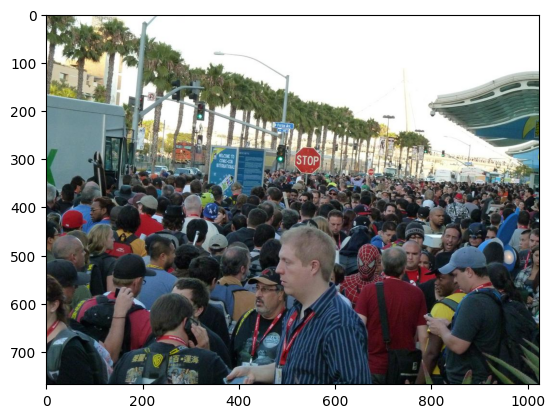

Predicted Count : 275
Real Count     : 236


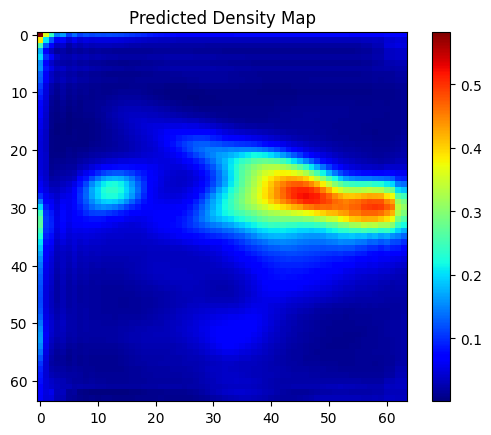

In [10]:
# init model
model = CSRNet()
# load weights
checkpoint = torch.load('fine_tuned_weights_early_stopped.pth', map_location="cpu")
model.load_state_dict(checkpoint)
model.eval()
# get real count of predicted image
real_count = len(test_gts[1])

# print image
print("Original Image")
plt.imshow(cv2.cvtColor(test_images[1], cv2.COLOR_BGR2RGB))
plt.show()

# compute prediction and compare counts
img = transform(Image.fromarray(test_images[1]).convert('RGB'))
output = model(img.unsqueeze(0))
pred_count = int(output.detach().cpu().sum().numpy())
print(f"Predicted Count : {pred_count}")
print(f"Real Count     : {real_count}")

# print density map
density_map = output.detach().cpu().squeeze().numpy()
plt.imshow(density_map, cmap='jet')
plt.colorbar()
plt.title("Predicted Density Map")
plt.show()

### Model metrics

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
from tqdm import tqdm

def predict_count(img):
    model.eval()
    image = transform(Image.fromarray(img))
    output = model(image.unsqueeze(0))
    pred = int(output.detach().cpu().sum().numpy())
    return pred

def evaluate_model(images, gts):
    predictions = []
    actual = []
    for img, gt in zip(tqdm(images), gts):
        pred = predict_count(img)
        predictions.append(pred)
        actual.append(len(gt))
    mae = mean_absolute_error(actual, predictions)
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    mape = np.mean(np.abs((np.array(actual) - np.array(predictions)) / np.array(actual))) * 100
    r2 = r2_score(actual, predictions)
    return {
        'predictions': predictions,
        'actual': actual,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'r2': r2
    }

def print_per_image_differences(results):
    actuals     = results['actual']
    preds       = results['predictions']
    print(f"{'Idx':>3} | {'Actual':>6} | {'Predicted':>9} | {'Diff':>6}")
    print("-"*32)
    for i, (a, p) in enumerate(zip(actuals, preds)):
        diff = p - a
        print(f"{i:>3} | {a:>6} | {p:>9} | {diff:>6}")

def run_evaluation():
    images = test_images
    gts = test_gts
    print("Running model evaluation...")
    results = evaluate_model(images, gts)

    print("\nMetrikos")
    print(f"MAE:  {results['mae']:.2f}")
    print(f"RMSE: {results['rmse']:.2f}")
    print(f"MAPE: {results['mape']:.2f}%")
    print(f"R2: {results['r2']:.4f}")

    print("\nSkirtumai:")
    print_per_image_differences(results)

run_evaluation()

Running model evaluation...


100%|██████████| 182/182 [07:45<00:00,  2.56s/it]


Metrikos
MAE:  185.19
RMSE: 258.81
MAPE: 64.64%
R2: 0.4639

Skirtumai:
Idx | Actual | Predicted |   Diff
--------------------------------
  0 |    218 |       373 |    155
  1 |    236 |       275 |     39
  2 |    986 |       508 |   -478
  3 |    357 |       612 |    255
  4 |    175 |       296 |    121
  5 |    604 |       312 |   -292
  6 |    395 |       210 |   -185
  7 |    211 |       268 |     57
  8 |     86 |       166 |     80
  9 |    122 |       272 |    150
 10 |    193 |       205 |     12
 11 |    440 |       600 |    160
 12 |    165 |       156 |     -9
 13 |    475 |       529 |     54
 14 |    250 |       321 |     71
 15 |    412 |       644 |    232
 16 |    208 |       524 |    316
 17 |    249 |       185 |    -64
 18 |    199 |       362 |    163
 19 |    246 |       384 |    138
 20 |    375 |       390 |     15
 21 |     97 |       136 |     39
 22 |    250 |       482 |    232
 23 |   1366 |      1492 |    126
 24 |    309 |       647 |    338
 25 |    11